# **Clustering des titres**

Le but de ce notebook est d'essayer de faire un clustering sur la colonne titres de notre fichier, afin de pouvoir ensuite donner un thème par cluster 

In [67]:
# Importation des bibliothèques nécessaires

import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
import numpy as np
from nltk.corpus import stopwords
import nltk
import spacy
from nltk.corpus import wordnet
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Télécharger les stop words français si nécessaire
nltk.download('stopwords', quiet=True)
french_stop_words = stopwords.words('french')
english_stop_words = stopwords.words('english')

In [ ]:
# Chargement des données 
data= pd.read_csv("../01.Data/Sources/articles.csv")
# Nombre d'articles 
print (data.shape[0])
print (data.columns)
# Remplacer le nom de la première colonne par "id"
data.rename(columns={data.columns[0]: "id"}, inplace=True)
print (data.columns)

1255
Index(['id', 'title', 'year', 'language', 'Nb_authors', 'Nb_male', 'Nb_female',
       'theme', 'keywords'],
      dtype='object')
Index(['id', 'title', 'year', 'language', 'Nb_authors', 'Nb_male', 'Nb_female',
       'theme', 'keywords'],
      dtype='object')


In [69]:
# Dans le fichier y'a des articles en français et en anglais 
data_fr = data[data['language'] == 'fr']
print (data_fr.shape[0])
data_en = data[data['language'] == 'en']
print (data_en.shape[0])

1133
122


# Traitement du français

In [70]:
!python -m spacy download fr_core_news_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/fr_core_news_sm-3.8.0/fr_core_news_sm-3.8.0-py3-none-any.whl (16.3 MB)
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [71]:
# Récupération du vocabulaire français à partir des titres des articles

import spacy
from spacy.lang.fr.stop_words import STOP_WORDS as french_stop_words

# Charger le modèle français
nlp = spacy.load("fr_core_news_sm")

# Initialiser un set vide pour le vocabulaire
vocab_fr = set()

for title in data_fr['title']:
    doc = nlp(title)
    for token in doc:
        # garder seulement les mots alphabétiques, minuscules, non stopwords
        lemma = token.lemma_.lower()
        if token.is_alpha and lemma not in french_stop_words:
            vocab_fr.add(lemma)

print("Nombre de mots uniques :", len(vocab_fr))


Nombre de mots uniques : 1924


In [72]:
print(vocab_fr)

{'communautaire', 'conceptuels', 'imprécis', 'classer', 'terme', 'tarification', 'avion', 'répétition', 'filtr', 'étoile', 'compteur', 'gène', 'similarité', 'import', 'vs', 'complétude', 'mécaniques', 'détermination', 'sparql', 'ordinal', 'géométrique', 'ouvrage', 'raisonnemer', 'nfb', 'limiter', 'cycle', 'agrégée', 'adapter', 'mixte', 'section', 'essieu', 'intelligible', 'trajectoire', 'patient', 'typologie', 'annotation', 'bloc', 'état', 'impliquer', 'obsolescence', 'tendance', 'afc', 'idée', 'épidémiologique', 'réutilisation', 'distribution', 'pervasif', 'pmi', 'théorie', 'autour', 'corréler', 'graphique', 'simplification', 'contraposée', 'intervall', 'catégorieller', 'plateforme', 'programmation', 'tic', 'différence', 'validation', 'caractérisation', 'm', 'protocole', 'grille', 'étiqueteur', 'compte', 'correspondance', 'crédibiliste', 'videosurveillance', 'explicite', 'discrétisation', 'suspect', 'pixel', 'hautement', 'rdbtoonto', 'cours', 'évaluation', 'participation', 'discours',

In [73]:
# Nettoyage manuel des mots non pertinents
manual_stop_words = {
    # Bruit & Lettres isolées
    'p', 'n', 'b', 'c', 'j', 'v', 'm', 'r', 'k', 'cl', 'sou', 'tr', 'vs', 'via', 'multi', 'intro', 'chapitre',
    
    # Termes génériques de recherche
    'approche', 'approches', 'méthode', 'méthodes', 'système', 'systèmes',
    'application', 'applications', 'analyse', 'analyses', 'étude', 'études',
    'modèle', 'modèles', 'modélisation', 'algorithme', 'algorithmes',
    'problème', 'problèmes', 'solution', 'solutions', 'résultat', 'résultats',
    'outil', 'outils', 'processus', 'technique', 'techniques', 'concept',
    'contexte', 'cadre', 'travail', 'travaux',
    'contribution', 'contributions', 'cas', 'exemple', 'exemples', 'usage',
    'utilisation', 'proposition', 'démarche', 'principe', 'théorie', 'théorique',
    'pratique', 'état', 'art', 'vue', 'niveau', 'type', 'moyen', 'question',
    'enjeu', 'domaine', 'sujet', 
    
    # Verbes courants (formes lemmatisées probables)
    'utiliser', 'permettre', 'baser', 'proposer', 'présenter','définir', 'construire', 'générer', 'traiter',
    'extraire', 'apprendre',  'considérer', 'mesurer', 'voir',
    'faire', 'obtenir','viser', 'fournir', 'intégrer',
    'mettre', 'partir',  'montrer', 'conclure',
    
    # Adjectifs / Adverbes vagues
    'nouveau', 'nouvelle', 'nouveaux', 'nouvelles', 'bon', 'meilleur',
    'grand', 'petit', 'simple',
    'général', 'efficace', 'performant', 'rapide',  'classique', 'possible',
    'nécessaire', 'principal', 'important', 'haut', 'faible', 'large',
    'court', 'long', 'très', 'trop', 'peu', 'bien', 'mieux'
}
vocab_fr = vocab_fr - manual_stop_words
print(len(vocab_fr))

1837


In [74]:
# Créons une colonne titre_clean en les mettant en miniscule sans stop word et en lemme 
def clean_title_fr(text):
    doc = nlp(text)
    return " ".join([token.lemma_.lower() 
                     for token in doc 
                     if token.is_alpha and token.lemma_.lower() not in french_stop_words])

# Appliquer sur la colonne 'title'
data_fr['title_clean'] = data_fr['title'].apply(clean_title_fr)

C:\Users\charl\AppData\Local\Temp\ipykernel_18124\4166352686.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fr['title_clean'] = data_fr['title'].apply(clean_title_fr)


In [75]:
# Construction de la matrice TF-IDF pour les articles en français en utilisant seulement les titres
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_fr = TfidfVectorizer(
    vocabulary=vocab_fr,  # on utilise le vocabulaire extrait précédemment
    max_df=0.8,                 # optionnel, mais sécuritaire
    min_df=2,                   # optionnel, mais sécuritaire
    ngram_range=(1, 2)          # unigrams et bigrams
)

# Construction de la matrice TF-IDF
tfidf_matrix_fr = vectorizer_fr.fit_transform(data_fr['title_clean'])
print("TF-IDF matrix shape (fr):", tfidf_matrix_fr.shape)


TF-IDF matrix shape (fr): (1133, 1837)


In [76]:
# Application du K-means 
# En regardant les résultats du challenge publiés, on constate que le nombre de clusters utilisé est 10
from sklearn.cluster import KMeans
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
data_fr["cluster"] = kmeans.fit_predict(tfidf_matrix_fr)

c:\Users\charl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\charl\AppData\Local\Temp\ipykernel_18124\462268148.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fr["cluster"] = kmeans.fit_predict(tfidf_matrix_fr)


In [77]:
terms = vectorizer_fr.get_feature_names_out()

In [78]:
# Chaque cluster a un centroïde (un vecteur) qui est la moyenne des vecteurs TF-IDF de tous les documents dans ce cluster.
# Chaque dimension du vecteur correspond à un mot de ton vocabulaire.
# Plus la valeur dans le centroïde pour un mot est grande, plus ce mot est représentatif des documents du cluster.
# Le code prend les n mots avec les plus grandes valeurs dans le centroïde → ce sont ceux qui définissent le cluster.
# Du coup le premier mot est le plus proche du thème du cluster
import numpy as np

def get_top_words_per_cluster(model, terms, n_words=10):
    for i, centroid in enumerate(model.cluster_centers_):
        top_indices = centroid.argsort()[-n_words:][::-1]
        top_terms = [terms[ind] for ind in top_indices]
        print(f"Cluster {i} : {', '.join(top_terms)}")
get_top_words_per_cluster(kmeans, terms)

Cluster 0 : ontologie, alignement, construction, sémantique, texte, guider, entrer, owl, dédier, relation
Cluster 1 : donnée, fouille, flux, base, entrepôt, visualisation, apprentissage, multidimensionnel, textuel, ensemble
Cluster 2 : motif, séquentiel, extraction, fréquent, découverte, donnée, contrainte, attribuer, graduel, base
Cluster 3 : règle, association, extraction, génération, recherche, classification, comparaison, exception, flou, entrer
Cluster 4 : réseau, apprentissage, sémantique, détection, graphe, social, recherche, information, mesure, clustering
Cluster 5 : séquence, temporel, série, spatio, événement, motif, extraction, classification, fréquent, flux
Cluster 6 : connaissance, extraction, gestion, base, donnée, compétence, information, acquisition, texte, expert
Cluster 7 : document, arbre, xml, décision, annotation, structure, recherche, classification, évaluation, classement
Cluster 8 : classification, superviser, non, donnée, sélection, image, automatique, visuali

In [79]:
for i in range(k):
    print(f"\n### Cluster {i}")
    print(data_fr[data_fr["cluster"] == i]["title"].head(3).values)


### Cluster 0
["Contraintes prescriptives compatibles avec OWL2-ER pour évaluer la complétude d'ontologies"
 "L'ontologie OntoBiotope pour l'étude de la biodiversité microbienne"
 "Vers une instance française de NELL : chaîne TLN multilingue et modélisation d'ontologie"]

### Cluster 1
['Apport de la fouille de données pour la prévention du risque suicidaire'
 'Interrogation de données structurellement hétérogènes dans les bases de données orientées documents'
 "L'exploitation de données contextuelles pour la recommandation d'hôtels"]

### Cluster 2
["Découverte de motifs graduels partiellement ordonnés : application aux données d'expériences scientifiques"
 'Echantillonnage de motifs séquentiels sous contrainte sur la norme'
 'Fouille de Motifs Graduels Fermés Fréquents Sous Contrainte de la Temporalité']

### Cluster 3
["Définir les catégories de DBpédia avec des règles d'associations et des redescriptions"
 "Sélection ciblée des descripteurs visuels pour la recherche d'images: une 

In [80]:
# Affichons le nombre d'articles par cluster
print(data_fr['cluster'].value_counts())

cluster
4    453
1    175
6    112
8     94
3     59
0     55
5     51
2     48
7     46
9     40
Name: count, dtype: int64


In [81]:
# On rajoute maintenant une colonne thème ou on correspond le thème à chaque cluster
cluster_themes = {
    0: "Web Sémantique",
    1: "Entrepôts de Données",
    2: "Fouille de Motifs",
    3: "Règles d'Association",
    4: "Analyse de Graphes",
    5: "Flux & Temporalité",
    6: "Ingénierie des Données",
    7: "Recherche d'Information",
    8: "Classification & Clustering",
    9: "Web Mining"
}

data_fr["theme"] = data_fr["cluster"].map(cluster_themes)
# On sauvgarde dans le meme fichier clustered_articles_fr.csv
data_fr.to_csv("clustered_articles_fr.csv", index=False)

C:\Users\charl\AppData\Local\Temp\ipykernel_18124\3861666029.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fr["theme"] = data_fr["cluster"].map(cluster_themes)


### Idées de représentations graphiques

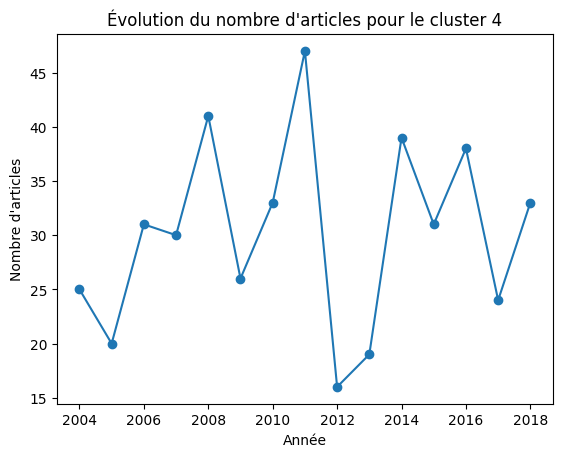

In [82]:
import matplotlib.pyplot as plt
cluster_id = 4
cluster_data = data_fr[data_fr['cluster'] == cluster_id]
articles_per_year = cluster_data['year'].value_counts().sort_index()
plt.plot(articles_per_year.index, articles_per_year.values, marker='o')
plt.xlabel("Année")
plt.ylabel("Nombre d'articles")
plt.title(f"Évolution du nombre d'articles pour le cluster {cluster_id}")
plt.show()

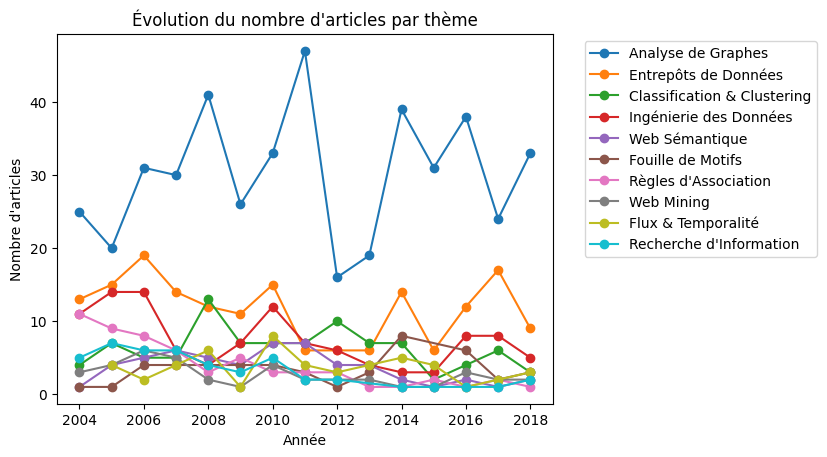

In [83]:
themes = data_fr['theme'].unique()
for theme in themes:
    theme_data = data_fr[data_fr['theme'] == theme]
    articles_per_year = theme_data['year'].value_counts().sort_index()
    plt.plot(articles_per_year.index, articles_per_year.values, marker='o', label=theme)
plt.xlabel("Année")
plt.ylabel("Nombre d'articles")
plt.title("Évolution du nombre d'articles par thème")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

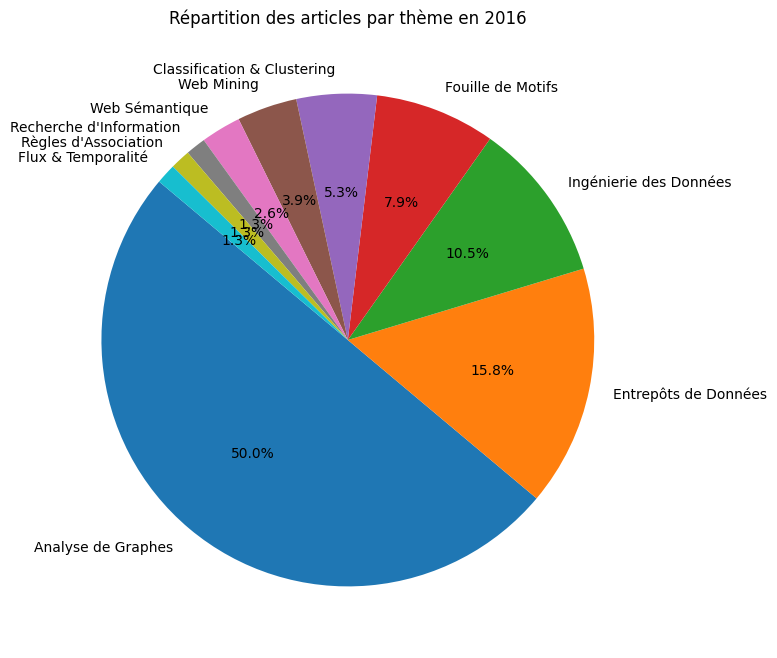

In [84]:
data_2016 = data_fr[data_fr['year'] == 2016]
articles_per_theme_2016 = data_2016['theme'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(articles_per_theme_2016.values, labels=articles_per_theme_2016.index, autopct='%1.1f%%', startangle=140)
plt.title("Répartition des articles par thème en 2016")
plt.show()

In [ ]:
from wordcloud import WordCloud
cluster_id = 4
cluster_data = data_fr[data_fr['cluster'] == cluster_id]
text = " ".join(cluster_data['title_clean'].values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"Nuage de mots pour le cluster {cluster_id}")
plt.show()

In [85]:
data_fr = data_fr.drop(['cluster'], axis=1)
data_fr.to_csv("clustered_articles_fr.csv", index=False)

# Traitement de l'anglais

In [ ]:
# Récupération du vocabulaire français à partir des titres des articles en anglais
# je veux le sauvgarder dans une liste 
vocab_en = set()
for title in data_en['title']:
    for word in title.split():
        vocab_en.add(word.lower())

print (len(vocab_en))
print ((vocab_en))

550
{'outlier', 'revisited', 'relational', 'interpreting', 'hierarchic', 'dawn', 'experience', 'classification', 'intrusion', 'patterns', 'genome-wide', 'scaling', 'vs', 'sequence', 'your', 'search', 'sparql', 'objective', 'memory', 'analytics:', 'worded', 'statistical', 'open-domain', 'visuel', 'social-attribute', 'documents', 'automatic', 'deriving', 'queries', 'finding', 'sampling', 'with', 'future', 'annotation', 'bibliographical', 'semantic', 'criteria', 'multi-block', 'dtmvic', ':', 'engine', 'representation', 'driven', 'geometry', 'avec', 'bayesian', 'fairness-aware', 'recent', '2.0', 'recommender', 'initiate', 'tag-based', 'smart', 'that', 'analytics', 'applications', 'shooting', 'parameter-free', 'present,', 'corporate', 'opportunities', 'identification', 'library', 'rough', 'reasoning', 'process', 'data', 'subspace', 'passage', "d'itemsets", 'when', 'have', '«', 'fast', 'enhanced', 'incompletely', 'fusion', 'compendium:', 'assumptions', 'regularized', 'influencers', 'sequenti

In [ ]:
# Lemmatisation

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lemmatiser_anglais(texte):
    doc = nlp(str(texte).lower())
    # On garde le lemme si ce n'est pas une ponctuation ou un stop word
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

data_en['title_lemmatize'] = data_en['title'].apply(lemmatiser_anglais)

C:\Users\charl\AppData\Local\Temp\ipykernel_18124\174525150.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_en['title_lemmatize'] = data_en['title'].apply(lemmatiser_anglais)


In [ ]:
# Affichage après lemmatisation
vocab_en = set()
for title in data_en['title_lemmatize']:
    for word in title.split():
        vocab_en.add(word.lower())

print (len(vocab_en))
print ((vocab_en))

458
{'outlier', 'relational', 'massive', 'hierarchic', 'sample', 'dawn', 'experience', 'classification', 'wide', 'intrusion', 'vs', 'sequence', 'vote', 'search', 'non', 'sparql', 'mysin', 'memory', 'objective', 'statistical', 'visuel', 'interactif', 'engage', 'automatic', 'rewrite', '0', 'future', 'annotation', 'bibliographical', 'compendium', 'semantic', 'spot', 'dtmvic', 'engine', 'distribution', 'representation', 'geometry', 'basis', 'avec', 'photograph', 'bayesian', 'value', 'recent', 'tree', '2.0', 'recommender', 'initiate', 'inférence', 'smart', 'coclustere', 'real', 'fairness', 'effectiveness', 'reveal', 'corporate', 'happen', 'identification', 'library', 'rough', 'reasoning', 'process', 'data', 'subspace', 'passage', 'fast', 'incompletely', 'fusion', 'shoot', 'app', 'sequential', 'coviz', 'summarization', 'contextualization', 'reason', 'maintenance', 'range', 'canonical', 'privacy', 'incremental', 'path', 'phrase', 'exploratoire', 'connecion', 'formalism', 'fringe', 'change', '

In [ ]:
# Désambiguïsation (regroupement de synonymes)

def reduire_synonymes(mot):
    # On cherche les synonymes du mot
    if len(str(mot)) <= 3:
        return mot
    synsets = wordnet.synsets(mot)
    if synsets:
        # On récupère le nom du premier concept (le plus commun)
        # ex: 'big' et 'large' pourraient tous deux renvoyer 'large'
        return synsets[0].lemmas()[0].name()
    return mot

def traiter_synonymes(texte_lemmatize):
    mots = str(texte_lemmatize).split()
    # Remplace chaque mot par son synonyme pivot
    mots_unifies = [reduire_synonymes(m) for m in mots]
    return " ".join(mots_unifies)

data_en['title_clean'] = data_en['title_lemmatize'].apply(traiter_synonymes)


C:\Users\charl\AppData\Local\Temp\ipykernel_18124\1868032106.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_en['title_clean'] = data_en['title_lemmatize'].apply(traiter_synonymes)


In [ ]:
# Affichage après désambiguïsation (regroupement de synonymes)
vocab_en = set()
for title in data_en['title_clean']:
    for word in title.split():
        vocab_en.add(word.lower())

print (len(vocab_en))
print ((vocab_en))

442
{'outlier', 'relational', 'massive', 'selling', 'sample', 'dawn', 'experience', 'wide', 'cognition', 'vs', 'sequence', 'vote', 'filter', 'search', 'non', 'sparql', 'mysin', 'memory', 'prosecute', 'statistical', 'visuel', 'interactif', 'visual_image', 'rewrite', '0', 'future', 'tilt', 'semantic', 'dtmvic', 'stopping_point', 'engine', 'distribution', 'representation', 'geometry', 'avec', 'photograph', 'novice', 'bayesian', 'value', 'tree', '2.0', 'recommender', 'inférence', 'smart', 'uncover', 'coclustere', 'disassociate', 'infusion', 'fairness', 'effectiveness', 'corporate', 'happen', 'library', 'rough', 'reasoning', 'audited_account', 'presently', 'data', 'subspace', 'passage', 'fast', 'incompletely', 'fusion', 'shoot', 'app', 'invasion', 'coviz', 'summarization', 'estimate', 'contextualization', 'reason', 'ocular', 'privacy', 'incremental', 'phrase', 'connecion', 'exploratoire', 'formalism', 'change', 'self', 'influencer', 'estate', 'hazard', 'behavior', 'small', 'unlabeled', 'use

In [ ]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 16.4 MB/s eta 0:00:01
     --------------------- ------------------ 6.8/12.8 MB 26.2 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 29.2 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 25.1 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# Construction de la matrice TF-IDF pour les articles en anglais en utilisant seulement les titres
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_en = TfidfVectorizer(
    vocabulary=vocab_en,  # on utilise le vocabulaire extrait précédemment
    max_df=0.8,                 # optionnel, mais sécuritaire
    min_df=2,                   # optionnel, mais sécuritaire
    ngram_range=(1, 2)          # unigrams et bigrams
)

# Construction de la matrice TF-IDF
tfidf_matrix_en = vectorizer_en.fit_transform(data_en['title_clean'])
print("TF-IDF matrix shape (en):", tfidf_matrix_en.shape)

TF-IDF matrix shape (en): (122, 442)


In [ ]:
inertia = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix_en)
    inertia.append(kmeans.inertia_)


c:\Users\charl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
terms = vectorizer_en.get_feature_names_out()

In [ ]:
import numpy as np

def get_top_words_per_cluster(model, terms, n_words=10):
    for i, centroid in enumerate(model.cluster_centers_):
        top_indices = centroid.argsort()[-n_words:][::-1]
        top_terms = [terms[ind] for ind in top_indices]
        print(f"Cluster {i} : {', '.join(top_terms)}")
get_top_words_per_cluster(kmeans, terms)

Cluster 0 : user, evaluation, retrieval, microblogge, colloquial, interaction, site, passage, open, ranking
Cluster 1 : network, model, ontology, learning, property, community, sociable, graph, machine, mine
Cluster 2 : extraction, information, semantic, text, complex, compact, kernel, system, intercede, processing
Cluster 3 : rule, discovery, association, set, base, database, stopping_point, action, relational, representative
Cluster 4 : stream, detect, data, anomaly, line, bunch, datum, detection, academician, plagiarism
Cluster 5 : datum, mining, constraint, big, categorization, scheduling, challenge, fusion, privacy, learn
Cluster 6 : analytic, ocular, problem, base, challenge, system, solve, bibliographic, keep, application
Cluster 7 : detection, outlier, collaborative, invasion, mobile, automaton, autonomous, small, antipattern, experiment
Cluster 8 : bunch, familial, heuristic, algorithm, entropic, base, network, visuel, interactif, ssc


In [ ]:
# Application du K-means 
# En regardant les résultats du challenge publiés, on constate que le nombre de clusters utilisé est 10
k = 9
kmeans = KMeans(n_clusters=k, random_state=42)
data_en["cluster"] = kmeans.fit_predict(tfidf_matrix_en)

C:\Users\charl\AppData\Local\Temp\ipykernel_18124\1160871002.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_en["cluster"] = kmeans.fit_predict(tfidf_matrix_en)


In [ ]:
for i in range(k):
    print(f"\n### Cluster {i}")
    print(data_en[data_en["cluster"] == i]["title"].values)


### Cluster 0
['Enhanced user-user collaborative filtering recommendation algorithm based on semantic ratings'
 '“Engage moi”: From retrieval effectiveness, user satisfaction to user engagement'
 'A Relevant Passage Retrieval and Re-ranking Approach for Open-Domain Question Answering'
 'Using Social Conversational Context For Detecting Users Interactions on Microblogging Sites'
 'User Evaluation: Why?']

### Cluster 1
['Big Data for understanding human dynamics: the power of networks'
 'Community structure in complex networks'
 'Long-range influences in (social) networks'
 'Reframing for Non-Linear Dataset Shift'
 'Temporal hints in the cultural heritage discourse: what can an ontology of time as it is worded reveal?'
 'Machine Learning Based Classification of Android Apps through Text Features'
 'Machine Learning for the Semantic Web: filling the gaps in Ontology Mining'
 'Analyse exploratoire par k-Coclustering avec Khiops CoViz'
 'TOM: A library for topic modeling and browsing'
 'A

In [ ]:
# 1. Compter le nombre de titres par cluster
counts = data_en['cluster'].value_counts().sort_index()

# 2. Affichage propre
print("Nombre de documents par cluster :")
print("-" * 30)
for cluster_id, count in counts.items():
    if cluster_id == -1:
        print(f"Bruit (Noise -1) : {count} documents")
    else:
        print(f"Cluster {cluster_id}      : {count} documents")

Nombre de documents par cluster :
------------------------------
Cluster 0      : 5 documents
Cluster 1      : 36 documents
Cluster 2      : 13 documents
Cluster 3      : 15 documents
Cluster 4      : 8 documents
Cluster 5      : 24 documents
Cluster 6      : 7 documents
Cluster 7      : 4 documents
Cluster 8      : 10 documents


In [ ]:
# Association des thèmes
mapping_clusters = {
    0: "Recherche d'Information",
    1: "Analyse de Graphes",
    2: "Web sémantique",
    3: "Règles d'Association",
    4: "Flux & Temporalité",
    5: "Big Data",
    6: "Visualisation",
    7: "Fouille de Motifs",
    8: "Classification & Clustering"
}

data_en['theme'] = data_en['cluster'].map(mapping_clusters)

for i in range(k):
    theme_nom = mapping_clusters.get(i, "Thème non défini")
    print(f"\n### Cluster {i} : {theme_nom}")
    print(data_en[data_en["cluster"] == i]["title"].values)


### Cluster 0 : Recherche d'Information
['Enhanced user-user collaborative filtering recommendation algorithm based on semantic ratings'
 '“Engage moi”: From retrieval effectiveness, user satisfaction to user engagement'
 'A Relevant Passage Retrieval and Re-ranking Approach for Open-Domain Question Answering'
 'Using Social Conversational Context For Detecting Users Interactions on Microblogging Sites'
 'User Evaluation: Why?']

### Cluster 1 : Analyse de Graphes
['Big Data for understanding human dynamics: the power of networks'
 'Community structure in complex networks'
 'Long-range influences in (social) networks'
 'Reframing for Non-Linear Dataset Shift'
 'Temporal hints in the cultural heritage discourse: what can an ontology of time as it is worded reveal?'
 'Machine Learning Based Classification of Android Apps through Text Features'
 'Machine Learning for the Semantic Web: filling the gaps in Ontology Mining'
 'Analyse exploratoire par k-Coclustering avec Khiops CoViz'
 'TOM:

C:\Users\charl\AppData\Local\Temp\ipykernel_18124\157716699.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_en['theme'] = data_en['cluster'].map(mapping_clusters)


In [ ]:
# export csv
data_en = data_en.drop(['cluster', 'title_lemmatize'], axis=1)
#data_en = data_en.drop(['title_clear'], axis=1)
data_en.to_csv("clustered_articles_en.csv", index=False)

# Merge des deux csv

In [ ]:
# Chargement
data_fr = pd.read_csv('clustered_articles_fr.csv', quotechar='"', skipinitialspace=True)
data_en = pd.read_csv('clustered_articles_en.csv', quotechar='"', skipinitialspace=True)

# Fusionner
df_final = pd.concat([data_fr, data_en], ignore_index=True)

# Sauvegarder le résultat
df_final.to_csv('clustered_articles.csv', index=False)
